In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from cryptocmd import CmcScraper

# initialise scraper without time interval
scraper = CmcScraper("BTC")

# get raw data as list of list
headers, data = scraper.get_data()

# get data in a json format
btc_json_data = scraper.get_data("json")

# Pandas dataFrame for the same data
btc_df = scraper.get_dataframe()
btc_df = pd.DataFrame(btc_df, columns=['Date','Close'])
btc_df.set_index('Date', inplace=True)
btc_df=btc_df.rename(columns = {'Close':'BTC'})
btc_df = btc_df.iloc[::-1]
btc_df.index = btc_df.index.tz_localize("UTC")
btc_df

,BTC
Date,
2013-04-28 00:00:00+00:00,134.210007
2013-04-29 00:00:00+00:00,144.539993
2013-04-30 00:00:00+00:00,139.000000
2013-05-01 00:00:00+00:00,116.989998
2013-05-02 00:00:00+00:00,105.209999
...,...
2022-03-05 00:00:00+00:00,39400.584138
2022-03-06 00:00:00+00:00,38419.983377
2022-03-07 00:00:00+00:00,38062.040206


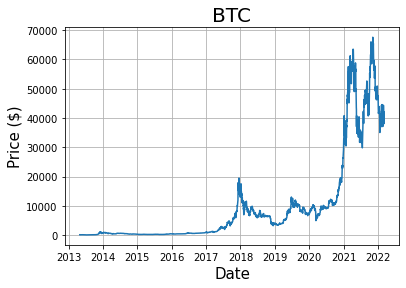

In [19]:
plt.plot(btc_df['BTC'])
plt.xlabel("Date", size=15)
plt.ylabel("Price ($)", size=15)
plt.title("BTC", size=20)
plt.grid()
plt.show()

Date
2013-04-28 00:00:00+00:00    0.000000
2013-04-29 00:00:00+00:00    0.076969
2013-04-30 00:00:00+00:00   -0.038328
2013-05-01 00:00:00+00:00   -0.158345
2013-05-02 00:00:00+00:00   -0.100692
                               ...   
2022-03-05 00:00:00+00:00    0.006719
2022-03-06 00:00:00+00:00   -0.024888
2022-03-07 00:00:00+00:00   -0.009317
2022-03-08 00:00:00+00:00    0.017740
2022-03-09 00:00:00+00:00    0.083786
Name: BTC, Length: 3238, dtype: float64

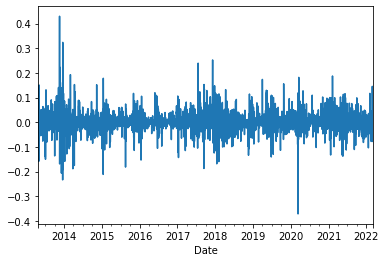

In [21]:
btc_daily_return = btc_df.pct_change().fillna(0).squeeze()
btc_daily_return.plot()
btc_daily_return

In [23]:
# get sp500 data

import pandas_datareader.data as web
import datetime

start = datetime.datetime(2013, 4, 27)
end = datetime.datetime(2022, 3, 9)
SP500 = web.DataReader(['sp500'], 'fred', start, end)
SP500=SP500.rename(columns = {'sp500':'SP500'})
SP500.index = SP500.index.tz_localize("UTC")
SP500

,SP500
DATE,
2013-04-29 00:00:00+00:00,1593.61
2013-04-30 00:00:00+00:00,1597.57
2013-05-01 00:00:00+00:00,1582.70
2013-05-02 00:00:00+00:00,1597.59
2013-05-03 00:00:00+00:00,1614.42
...,...
2022-03-03 00:00:00+00:00,4363.49
2022-03-04 00:00:00+00:00,4328.87
2022-03-07 00:00:00+00:00,4201.09


<AxesSubplot:title={'center':'S&P 500 Price'}, xlabel='DATE'>

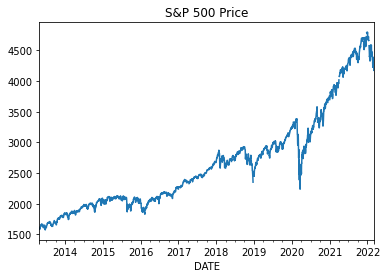

In [24]:
SP500['SP500'].plot(title='S&P 500 Price')

<AxesSubplot:xlabel='DATE'>

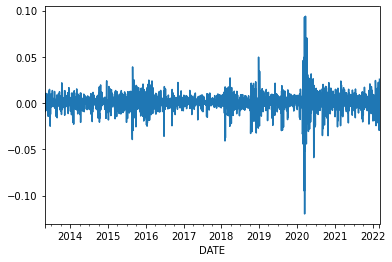

In [26]:
sp500_daily_return = SP500['SP500'].pct_change(1).fillna(0)
sp500_daily_return
sp500_daily_return.plot()

In [28]:
import pyfolio as pf
# silence warnings
import warnings
warnings.filterwarnings('ignore')

Start date,2013-04-29
End date,2022-03-09
Total months,110
,Backtest
Annual return,61.002%
Cumulative returns,7814.368%
Annual volatility,71.849%
Sharpe ratio,1.02
Calmar ratio,0.74
Stability,0.88
Max drawdown,-82.398%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,82.40,2017-12-15,2018-12-14,2020-11-17,763
1,78.88,2013-12-04,2015-01-14,2017-05-03,891
2,51.96,2021-10-20,2022-01-21,NaT,NaN
3,51.76,2013-04-29,2013-07-05,2013-11-05,137
4,50.35,2021-05-05,2021-07-20,2021-10-20,121


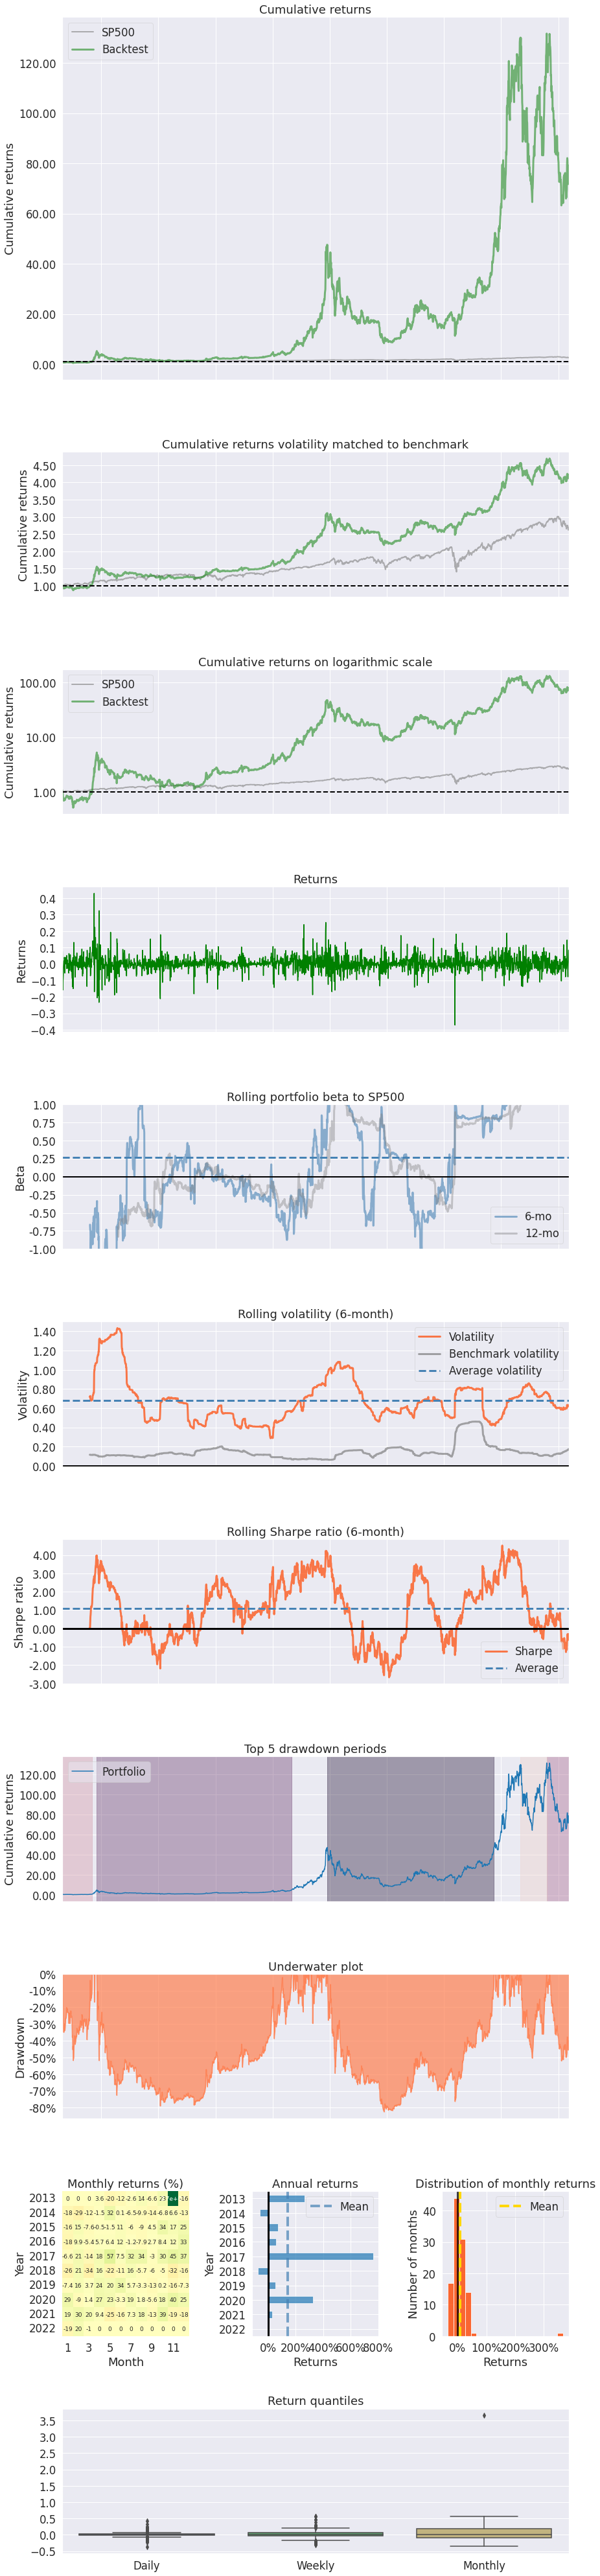

In [30]:
pf.create_returns_tear_sheet(btc_daily_return, benchmark_rets=sp500_daily_return)
#pf.create_returns_tear_sheet(sp500_daily_return, benchmark_rets=btc_daily_return.squeeze())